In [2]:
import os
import torch
import torchvision
from torch import nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [63]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

batch_size = 32

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [64]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


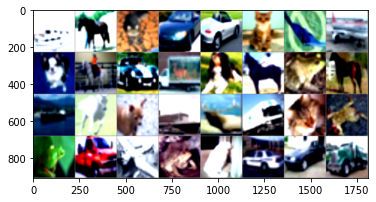

 shiphorse  cat  car  car  catplaneplane  doghorse  cartruck  doghorse froghorse shiphorse  dog ship deertruck  cat frog frogtruckplane frog  cat  car  cartruck


In [65]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(''.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [66]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super().__init__()
        '''
        torch.nn.Conv2d(
            in_channels, out_channels, kernel_size, stride,
            padding, padding_mode, dilation, groups, bias
            )

        torch.nn.ReLU(
            inplace     : 출력을 할당하지 않고 입력을 직접 수정
            )
        '''
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=96),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=384),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=384),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256),

            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [67]:
alexNet = AlexNet(len(classes))
alexNet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d

In [68]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexNet.parameters(), lr=0.001, momentum=0.9)

In [69]:
for epoch in range(10):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte/59013131
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = alexNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.977
[1,   200] loss: 1.696
[1,   300] loss: 1.553
[1,   400] loss: 1.497
[1,   500] loss: 1.417
[1,   600] loss: 1.370
[1,   700] loss: 1.350
[1,   800] loss: 1.266
[1,   900] loss: 1.232
[1,  1000] loss: 1.218
[1,  1100] loss: 1.155
[1,  1200] loss: 1.121
[1,  1300] loss: 1.059
[1,  1400] loss: 1.107
[1,  1500] loss: 1.069
[2,   100] loss: 0.980
[2,   200] loss: 0.966
[2,   300] loss: 0.928
[2,   400] loss: 0.945
[2,   500] loss: 0.939
[2,   600] loss: 0.938
[2,   700] loss: 0.893
[2,   800] loss: 0.878
[2,   900] loss: 0.895
[2,  1000] loss: 0.853
[2,  1100] loss: 0.871
[2,  1200] loss: 0.863
[2,  1300] loss: 0.841
[2,  1400] loss: 0.803
[2,  1500] loss: 0.838
[3,   100] loss: 0.758
[3,   200] loss: 0.737
[3,   300] loss: 0.753
[3,   400] loss: 0.739
[3,   500] loss: 0.731
[3,   600] loss: 0.725
[3,   700] loss: 0.718
[3,   800] loss: 0.728
[3,   900] loss: 0.668
[3,  1000] loss: 0.750
[3,  1100] loss: 0.689
[3,  1200] loss: 0.689
[3,  1300] loss: 0.732
[3,  1400] 

In [70]:
PATH = './cifar_net.pth'
torch.save(alexNet.state_dict(), PATH)

In [71]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [72]:
PATH = './cifar_net.pth'
alexNet = AlexNet(len(classes))
alexNet.load_state_dict(torch.load(PATH))
alexNet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d

In [73]:
outputs = alexNet(images.cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


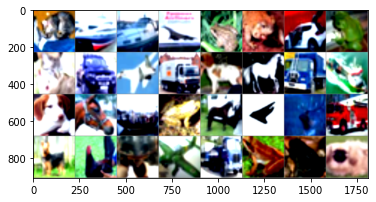

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog
Predicted:    cat  ship   car plane  frog  frog   cat  frog   cat truck   cat truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog


In [74]:
_, predicted = torch.max(outputs, 1)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [75]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = alexNet(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %


In [76]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        outputs = alexNet(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 81.9 %
Accuracy for class car   is: 90.5 %
Accuracy for class bird  is: 68.5 %
Accuracy for class cat   is: 62.8 %
Accuracy for class deer  is: 81.2 %
Accuracy for class dog   is: 79.0 %
Accuracy for class frog  is: 86.6 %
Accuracy for class horse is: 85.0 %
Accuracy for class ship  is: 90.0 %
Accuracy for class truck is: 86.9 %
